<a href="https://colab.research.google.com/github/rxymitchy/Colabnotebooks/blob/main/PT_Repeated_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [ ]:
class ProspectTheory:
    """Complete PT implementation for game analysis"""

    def __init__(self, lambd=2.25, alpha=0.88, gamma=0.61, r=0):
        self.lambd = lambd  # Loss aversion
        self.alpha = alpha  # Diminishing sensitivity
        self.gamma = gamma  # Probability weighting
        self.r = r          # Reference point

    def value_function(self, x):
        """PT value function v(x)"""
        if x >= 0:
            return (x + 1e-10) ** self.alpha
        else:
            return -self.lambd * ((-x + 1e-10) ** self.alpha)

    def probability_weighting(self, p):
        """Prelec probability weighting function"""
        # Why are we using the Prelec function but defining a different one in the paper?
        if p <= 0:
            return 0
        elif p >= 1:
            return 1
        else:
            return np.exp(-np.power(-np.log(p), self.gamma))

    def expected_pt_value(self, outcomes, probabilities):
        """Calculate PT expected value with probability weighting"""
        ''' We need to differentiate between gains and losses, taking the cdf for
        losses only and the decumulative df for gains. Right now this takes the cdf
        for everything.
        '''
        weighted_sum = 0
        sorted_indices = np.argsort(outcomes)[::-1]  # Sort descending

        for idx in sorted_indices:
            outcome = outcomes[idx]
            prob = probabilities[idx]
            if prob > 0:
                # Cumulative probability for rank-dependent weighting
                # We need to take the decumulative density function for gains
                rank = np.sum(probabilities[sorted_indices[:idx+1]])
                prev_rank = rank - prob

                # Decision weight = w(rank) - w(prev_rank)
                # We need to separate this into curr - prev and curr + next (M^- + M^+)
                weight = self.probability_weighting(rank) - self.probability_weighting(prev_rank)
                weighted_sum += weight * outcome

        return weighted_sum


In [ ]:
def get_all_games():
    """Return all games for testing"""
    return {
        'PrisonersDilemma': {
            'payoffs': np.array([
                [[-1, -1], [-3, 0]],   # C/C, C/D
                [[0, -3], [-2, -2]]    # D/C, D/D
            ]),
            'description': 'Classic Prisoner\'s Dilemma',
            'actions': ['Cooperate', 'Defect']
        },
        'MatchingPennies': {
            'payoffs': np.array([
                [[1, -1], [-1, 1]],   # H/H, H/T
                [[-1, 1], [1, -1]]    # T/H, T/T
            ]),
            'description': 'Zero-sum Matching Pennies',
            'actions': ['Heads', 'Tails']
        },
        'BattleOfSexes': {
            'payoffs': np.array([
                [[2, 1], [0, 0]],    # Opera/Opera, Opera/Football
                [[0, 0], [1, 2]]     # Football/Opera, Football/Football
            ]),
            'description': 'Battle of the Sexes',
            'actions': ['Opera', 'Football']
        },
        'StagHunt': {
            'payoffs': np.array([
                [[4, 4], [0, 3]],    # Stag/Stag, Stag/Hare
                [[3, 0], [2, 2]]     # Hare/Stag, Hare/Hare
            ]),
            'description': 'Stag Hunt Coordination Game',
            'actions': ['Stag', 'Hare']
        },
        'Chicken': {
            'payoffs': np.array([
                [[0, 0], [-1, 1]],   # Straight/Straight, Straight/Swerve
                [[1, -1], [-10, -10]] # Swerve/Straight, Swerve/Swerve
            ]),
            'description': 'Chicken Game',
            'actions': ['Straight', 'Swerve']
        }
    }


In [ ]:
class AwareHumanPTAgent:
    """
    Sophisticated Aware Human PT Agent
    Knows the game structure and uses PT to compute best responses
    """

    def __init__(self, payoff_matrix, pt_params, agent_id=0):
        self.payoff_matrix = payoff_matrix
        self.pt = ProspectTheory(**pt_params)
        self.agent_id = agent_id  # 0 for row player, 1 for column player
        self.opponent_history = []
        self.my_history = []
        self.learning_rate = 0.1

        # Compute PT value matrix once
        self.pt_matrix = self._compute_pt_matrix()

        # Track opponent strategy estimate
        self.opponent_strategy_est = 0.5  # Initially assume uniform

    def _compute_pt_matrix(self):
        """Compute PT values for all outcomes"""
        pt_matrix = np.zeros_like(self.payoff_matrix)
        for i in range(2):
            for j in range(2):
                for player in [0, 1]:
                    payoff = self.payoff_matrix[i, j, player]
                    pt_matrix[i, j, player] = self.pt.value_function(payoff - self.pt.r)
        return pt_matrix

    def estimate_opponent_strategy(self, window=50):
        """Estimate opponent's mixed strategy using Bayesian updating"""
        if len(self.opponent_history) < 10:
            return 0.5  # Insufficient data

        # Use recent history
        recent = self.opponent_history[-window:] if window else self.opponent_history
        count_0 = sum(1 for a in recent if a == 0)
        total = len(recent)

        # Bayesian estimate with Beta(1,1) prior
        alpha = 1 + count_0
        beta = 1 + (total - count_0)
        return alpha / (alpha + beta)

    def compute_best_response(self, opponent_strat):
        """
        Compute PT best response to opponent's strategy
        Returns probability of playing action 0
        """
        # Expected PT values for each of our actions
        expected_values = []

        for my_action in [0, 1]:
            # Possible opponent actions
            outcomes = []
            probabilities = []

            for opp_action in [0, 1]:
                # Get PT value for this outcome
                if self.agent_id == 0:  # Row player
                    pt_value = self.pt_matrix[my_action, opp_action, 0]
                else:  # Column player
                    pt_value = self.pt_matrix[opp_action, my_action, 1]

                # Probability of opponent action
                prob = opponent_strat if opp_action == 0 else (1 - opponent_strat)

                outcomes.append(pt_value)
                probabilities.append(prob)

            # Calculate PT expected value
            exp_val = self.pt.expected_pt_value(np.array(outcomes), np.array(probabilities))
            expected_values.append(exp_val)

        # Softmax response based on PT values
        exp_values = np.array(expected_values)
        exp_values = np.exp(exp_values - np.max(exp_values))  # Numerical stability
        probabilities = exp_values / np.sum(exp_values)

        return probabilities[0]  # Probability of playing action 0

    def act(self, training=True, exploration_rate=0.1):
        """Choose action based on PT analysis"""
        # Estimate opponent strategy
        opp_strat = self.estimate_opponent_strategy()

        # Compute optimal probability for action 0
        p_optimal = self.compute_best_response(opp_strat)

        # Exploration during training
        if training and random.random() < exploration_rate:
            action = random.choice([0, 1])
        else:
            # Stochastic best response
            action = 0 if random.random() < p_optimal else 1

        return action

    def update(self, my_action, opponent_action, reward=None):
        """Update history after playing"""
        self.my_history.append(my_action)
        self.opponent_history.append(opponent_action)

        # Update strategy estimate (exponential smoothing)
        if len(self.opponent_history) > 1:
            recent_opp_0 = sum(1 for a in self.opponent_history[-10:] if a == 0) / min(10, len(self.opponent_history))
            self.opponent_strategy_est = (1 - self.learning_rate) * self.opponent_strategy_est + \
                                         self.learning_rate * recent_opp_0

    def get_strategy(self):
        """Get current strategy estimate"""
        opp_strat = self.estimate_opponent_strategy()
        p_optimal = self.compute_best_response(opp_strat)
        return p_optimal

In [ ]:
class LearningHumanPTAgent:
    """
    Learning Human PT Agent
    Doesn't know game structure, learns via RL
    Transforms rewards through PT
    """

    def __init__(self, state_size, action_size, pt_params, agent_id=0):
        self.state_size = state_size
        self.action_size = action_size
        self.pt = ProspectTheory(**pt_params)
        self.agent_id = agent_id

        # Q-learning parameters
        self.gamma = 0.95
        self.epsilon = 0.3
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Neural network
        self.q_net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Experience replay
        self.memory = deque(maxlen=2000)
        self.batch_size = 32

        # Track raw vs PT rewards
        self.raw_rewards = []
        self.pt_rewards = []

    def transform_reward(self, reward):
        """Transform raw reward through PT value function"""
        pt_reward = self.pt.value_function(reward - self.pt.r)
        self.raw_rewards.append(reward)
        self.pt_rewards.append(pt_reward)
        return pt_reward

    def remember(self, state, action, reward, next_state, done):
        """Store experience with PT-transformed reward"""
        pt_reward = self.transform_reward(reward)
        self.memory.append((state, action, pt_reward, next_state, done))

    def act(self, state, training=True):
        """Choose action using epsilon-greedy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return torch.argmax(q_values).item()

    def replay(self):
        """Train on experiences"""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Current Q values
        current_q = self.q_net(states).gather(1, actions).squeeze()

        # Next Q values
        with torch.no_grad():
            next_q = self.q_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Train
        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update(self, my_action, opponent_action, reward=None):
        """Update agent (for compatibility)"""
        pass

    def get_pt_stats(self):
        """Get statistics about PT transformation"""
        if not self.raw_rewards:
            return {"mean_raw": 0, "mean_pt": 0, "std_raw": 0, "std_pt": 0}

        return {
            "mean_raw": np.mean(self.raw_rewards[-100:]),
            "mean_pt": np.mean(self.pt_rewards[-100:]),
            "std_raw": np.std(self.raw_rewards[-100:]),
            "std_pt": np.std(self.pt_rewards[-100:])
        }


In [ ]:
class AIAgent:
    """Standard RL agent without PT"""

    def __init__(self, state_size, action_size, agent_id=0):
        self.state_size = state_size
        self.action_size = action_size
        self.agent_id = agent_id

        # Q-learning parameters
        self.gamma = 0.95
        self.epsilon = 0.3
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Neural network
        self.q_net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Experience replay
        self.memory = deque(maxlen=2000)
        self.batch_size = 32

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Current Q values
        current_q = self.q_net(states).gather(1, actions).squeeze()

        # Next Q values
        with torch.no_grad():
            next_q = self.q_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Train
        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update(self, my_action, opponent_action, reward=None):
        pass


In [ ]:
class RepeatedGameEnv:
    """Environment for repeated 2x2 games"""

    def __init__(self, payoff_matrix, horizon=100, state_history=3):
        self.payoff_matrix = payoff_matrix
        self.horizon = horizon
        self.state_history = state_history
        self.state_size = state_history * 4  # 4 possible action pairs

    def reset(self):
        self.round = 0
        self.history = []
        return self._get_state()

    def _get_state(self):
        """State: one-hot encoding of last action pairs"""
        state = np.zeros(self.state_size, dtype=np.float32)

        for i in range(min(self.state_history, len(self.history))):
            action1, action2 = self.history[-(i+1)]
            idx = i * 4
            if action1 == 0 and action2 == 0:
                state[idx] = 1
            elif action1 == 0 and action2 == 1:
                state[idx + 1] = 1
            elif action1 == 1 and action2 == 0:
                state[idx + 2] = 1
            else:  # 1,1
                state[idx + 3] = 1

        return state

    def step(self, action1, action2):
        reward1 = float(self.payoff_matrix[action1, action2, 0])
        reward2 = float(self.payoff_matrix[action1, action2, 1])

        self.history.append((action1, action2))
        self.round += 1

        done = self.round >= self.horizon
        return self._get_state(), reward1, reward2, done, {}


In [ ]:
# Double Auction Game
class DoubleAuction:
  def __init__(self, k=100):
    self.A = set(range(k+1))
    self.B = set(range(k+1))
    self.k = k

    # Static, arbitrary valuation and costs for now.
    # I'll spend some time figuring out how to handle this
    self.valuation = 65
    self.cost = 45

  def reset(self):
    self.valuation = np.random.randint(0, 101)
    self.cost = np.random.randint(0, 101)

  def step(self, bid, ask):

    assert bid in self.B and ask in self.A

    # If a successful trade
    if bid >= ask:
      price = (bid + ask) / 2
      buyer_payoff = self.valuation - price
      seller_payoff = price - self.cost
      return buyer_payoff, seller_payoff

    else:
      return 0, 0


In [ ]:
def train_agents(agent1, agent2, env, episodes=500,
                 exploration_decay=0.99, verbose=True):
    """
    Train two agents against each other
    """

    results = {
        'rewards1': [],
        'rewards2': [],
        'actions1': [],
        'actions2': [],
        'avg_rewards1': [],
        'avg_rewards2': [],
        'strategies1': [],  # For aware PT agent
        'strategies2': []
    }

    exploration_rate = 0.3

    for episode in range(episodes):
        state = env.reset()
        episode_rewards1 = 0
        episode_rewards2 = 0
        episode_actions1 = []
        episode_actions2 = []

        # Get initial strategies (for aware PT agents)
        if hasattr(agent1, 'get_strategy'):
            results['strategies1'].append(agent1.get_strategy())
        if hasattr(agent2, 'get_strategy'):
            results['strategies2'].append(agent2.get_strategy())

        for _ in range(env.horizon):
            # Agent 1 chooses action
            if isinstance(agent1, AwareHumanPTAgent):
                action1 = agent1.act(training=True, exploration_rate=exploration_rate)
            else:
                action1 = agent1.act(state, training=True)

            # Agent 2 chooses action
            if isinstance(agent2, AwareHumanPTAgent):
                action2 = agent2.act(training=True, exploration_rate=exploration_rate)
            else:
                action2 = agent2.act(state, training=True)

            # Execute step
            next_state, reward1, reward2, done, _ = env.step(action1, action2)

            # Store experiences for RL agents
            if isinstance(agent1, (LearningHumanPTAgent, AIAgent)):
                agent1.remember(state.copy(), action1, reward1, next_state.copy(), done)
            if isinstance(agent2, (LearningHumanPTAgent, AIAgent)):
                agent2.remember(state.copy(), action2, reward2, next_state.copy(), done)

            # Update aware PT agents
            if isinstance(agent1, AwareHumanPTAgent):
                agent1.update(action1, action2, reward1)
            if isinstance(agent2, AwareHumanPTAgent):
                agent2.update(action2, action1, reward2)

            # Store results
            episode_rewards1 += reward1
            episode_rewards2 += reward2
            episode_actions1.append(action1)
            episode_actions2.append(action2)

            state = next_state

            if done:
                break

        # Train RL agents
        if isinstance(agent1, (LearningHumanPTAgent, AIAgent)):
            agent1.replay()
        if isinstance(agent2, (LearningHumanPTAgent, AIAgent)):
            agent2.replay()

        # Store episode results
        avg_reward1 = episode_rewards1 / env.horizon
        avg_reward2 = episode_rewards2 / env.horizon

        results['rewards1'].append(episode_rewards1)
        results['rewards2'].append(episode_rewards2)
        results['actions1'].append(episode_actions1)
        results['actions2'].append(episode_actions2)
        results['avg_rewards1'].append(avg_reward1)
        results['avg_rewards2'].append(avg_reward2)

        # Decay exploration
        exploration_rate *= exploration_decay

        # Progress update
        if verbose and (episode + 1) % 100 == 0:
            print(f"  Episode {episode + 1}/{episodes}: "
                  f"Avg rewards = {avg_reward1:.3f}, {avg_reward2:.3f}")

    return results

def analyze_matchup(results, agent1_type, agent2_type, game_name, games_dict):
    """Comprehensive analysis of a matchup"""

    actions = games_dict[game_name]['actions']

    fig = plt.figure(figsize=(15, 10))

    # 1. Learning curves
    ax1 = plt.subplot(2, 3, 1)
    window = 20
    smoothed1 = np.convolve(results['avg_rewards1'], np.ones(window)/window, mode='valid')
    smoothed2 = np.convolve(results['avg_rewards2'], np.ones(window)/window, mode='valid')

    ax1.plot(smoothed1, label=f'{agent1_type}', linewidth=2)
    ax1.plot(smoothed2, label=f'{agent2_type}', linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward (smoothed)')
    ax1.set_title(f'Learning Curves\n{agent1_type} vs {agent2_type}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Final strategy patterns
    ax2 = plt.subplot(2, 3, 2)
    if results['actions1'] and results['actions2']:
        last_episode = -1
        final_rounds = 50

        actions1 = results['actions1'][last_episode][-final_rounds:]
        actions2 = results['actions2'][last_episode][-final_rounds:]

        ax2.plot(actions1, 'o-', markersize=4, label=f'{agent1_type}', alpha=0.7)
        ax2.plot(actions2, 's-', markersize=4, label=f'{agent2_type}', alpha=0.7)
        ax2.set_xlabel(f'Round (last {final_rounds})')
        ax2.set_ylabel('Action')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(actions)
        ax2.set_title('Final Strategy Pattern')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Action distribution
    ax3 = plt.subplot(2, 3, 3)
    if results['actions1']:
        # Last 10 episodes
        recent_actions1 = [a for ep in results['actions1'][-10:] for a in ep]
        recent_actions2 = [a for ep in results['actions2'][-10:] for a in ep]

        bins = np.arange(-0.5, 2.5, 1)
        ax3.hist([recent_actions1, recent_actions2], bins=bins,
                label=[f'{agent1_type}', f'{agent2_type}'],
                alpha=0.7, align='mid')
        ax3.set_xlabel('Action')
        ax3.set_ylabel('Frequency')
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels(actions)
        ax3.set_title('Action Distribution (last 10 episodes)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # 4. Strategy evolution (for aware PT)
    ax4 = plt.subplot(2, 3, 4)
    if 'strategies1' in results and results['strategies1']:
        ax4.plot(results['strategies1'], label=f'{agent1_type} strategy', linewidth=2)
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Probability of Action 0')
        ax4.set_title('Strategy Evolution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim([0, 1])

    # 5. Cumulative rewards
    ax5 = plt.subplot(2, 3, 5)
    cumulative1 = np.cumsum(results['rewards1'])
    cumulative2 = np.cumsum(results['rewards2'])

    ax5.plot(cumulative1, label=f'{agent1_type}', linewidth=2)
    ax5.plot(cumulative2, label=f'{agent2_type}', linewidth=2)
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Cumulative Reward')
    ax5.set_title('Cumulative Rewards')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Reward distribution
    ax6 = plt.subplot(2, 3, 6)
    last_100_1 = results['avg_rewards1'][-100:] if len(results['avg_rewards1']) >= 100 else results['avg_rewards1']
    last_100_2 = results['avg_rewards2'][-100:] if len(results['avg_rewards2']) >= 100 else results['avg_rewards2']

    ax6.boxplot([last_100_1, last_100_2], labels=[agent1_type, agent2_type])
    ax6.set_ylabel('Average Reward')
    ax6.set_title('Reward Distribution (last 100 episodes)')
    ax6.grid(True, alpha=0.3)

    plt.suptitle(f'{game_name}: {agent1_type} vs {agent2_type}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*70)
    print(f"SUMMARY: {game_name} - {agent1_type} vs {agent2_type}")
    print("="*70)

    if results['avg_rewards1']:
        # Final performance
        final_episodes = 50
        if len(results['avg_rewards1']) >= final_episodes:
            final_avg1 = np.mean(results['avg_rewards1'][-final_episodes:])
            final_avg2 = np.mean(results['avg_rewards2'][-final_episodes:])
            std1 = np.std(results['avg_rewards1'][-final_episodes:])
            std2 = np.std(results['avg_rewards2'][-final_episodes:])

            print(f"\nFinal {final_episodes} episodes:")
            print(f"  {agent1_type}: {final_avg1:.3f} ± {std1:.3f}")
            print(f"  {agent2_type}: {final_avg2:.3f} ± {std2:.3f}")

            # Convergence check
            if std1 < 0.15 and std2 < 0.15:
                print("  ✓ Strategies converged (low variance)")
            else:
                print("  ⚠ Strategies still varying")

        # Action frequencies
        if results['actions1']:
            last_10_actions1 = [a for ep in results['actions1'][-10:] for a in ep]
            last_10_actions2 = [a for ep in results['actions2'][-10:] for a in ep]

            freq1_0 = np.mean([a == 0 for a in last_10_actions1])
            freq2_0 = np.mean([a == 0 for a in last_10_actions2])

            print(f"\nFinal action frequencies (Action 0 = {actions[0]}):")
            print(f"  {agent1_type}: {freq1_0:.1%}")
            print(f"  {agent2_type}: {freq2_0:.1%}")

            # PT stats for learning PT agent
            if hasattr(agent1, 'get_pt_stats'):
                stats = agent1.get_pt_stats()
                print(f"\nPT Transformation Stats for {agent1_type}:")
                print(f"  Mean raw reward: {stats['mean_raw']:.3f}")
                print(f"  Mean PT reward: {stats['mean_pt']:.3f}")
                print(f"  PT amplification: {stats['mean_pt']/max(0.001, stats['mean_raw']):.2f}x")

            if hasattr(agent2, 'get_pt_stats'):
                stats = agent2.get_pt_stats()
                print(f"\nPT Transformation Stats for {agent2_type}:")
                print(f"  Mean raw reward: {stats['mean_raw']:.3f}")
                print(f"  Mean PT reward: {stats['mean_pt']:.3f}")
                print(f"  PT amplification: {stats['mean_pt']/max(0.001, stats['mean_raw']):.2f}x")


In [ ]:
def run_complete_experiment(game_name, payoff_matrix, episodes=300):
    """Run all agent matchups for a game"""

    print("\n" + "="*80)
    print(f"COMPLETE EXPERIMENT: {game_name}")
    print("="*80)

    # Standard PT parameters
    pt_params = {
        'lambd': 2.25,   # Loss aversion
        'alpha': 0.88,   # Diminishing sensitivity
        'gamma': 0.61,   # Probability weighting
        'r': 0           # Reference point
    }

    # Create environment
    env = RepeatedGameEnv(payoff_matrix, horizon=100, state_history=2)

    # Define all matchups to test
    matchups = [
        ('Aware_PT', 'AI'),
        ('Learning_PT', 'AI'),
        ('Aware_PT', 'Learning_PT'),
        ('AI', 'AI')  # Baseline
    ]

    all_results = {}

    for agent1_type, agent2_type in matchups:
        print(f"\n{'='*70}")
        print(f"MATCHUP: {agent1_type} vs {agent2_type}")
        print('='*70)

        # Reset environment
        env = RepeatedGameEnv(payoff_matrix, horizon=100, state_history=2)

        # Create agents based on type
        if agent1_type == 'Aware_PT':
            agent1 = AwareHumanPTAgent(payoff_matrix, pt_params, agent_id=0)
        elif agent1_type == 'Learning_PT':
            agent1 = LearningHumanPTAgent(env.state_size, 2, pt_params, agent_id=0)
        else:  # AI
            agent1 = AIAgent(env.state_size, 2, agent_id=0)

        if agent2_type == 'Aware_PT':
            agent2 = AwareHumanPTAgent(payoff_matrix, pt_params, agent_id=1)
        elif agent2_type == 'Learning_PT':
            agent2 = LearningHumanPTAgent(env.state_size, 2, pt_params, agent_id=1)
        else:  # AI
            agent2 = AIAgent(env.state_size, 2, agent_id=1)

        # Train the matchup
        print(f"Training {episodes} episodes...")
        results = train_agents(agent1, agent2, env, episodes=episodes, verbose=True)

        # Store results
        matchup_key = f"{agent1_type}_vs_{agent2_type}"
        all_results[matchup_key] = {
            'results': results,
            'agent1': agent1,
            'agent2': agent2
        }

        # Analyze this matchup
        games_dict = get_all_games()
        analyze_matchup(results, agent1_type, agent2_type, game_name, games_dict)

    return all_results

def compare_all_results(all_results, game_name):
    """Compare performance across all matchups"""

    print("\n" + "="*80)
    print(f"COMPARISON ACROSS ALL MATCHUPS: {game_name}")
    print("="*80)

    comparison_data = []

    for matchup_key, data in all_results.items():
        results = data['results']

        if results['avg_rewards1'] and len(results['avg_rewards1']) >= 50:
            final_avg1 = np.mean(results['avg_rewards1'][-50:])
            final_avg2 = np.mean(results['avg_rewards2'][-50:])
            std1 = np.std(results['avg_rewards1'][-50:])
            std2 = np.std(results['avg_rewards2'][-50:])

            comparison_data.append({
                'Matchup': matchup_key,
                'Agent1_Avg': final_avg1,
                'Agent1_Std': std1,
                'Agent2_Avg': final_avg2,
                'Agent2_Std': std2,
                'Total_Avg': (final_avg1 + final_avg2) / 2,
                'Difference': abs(final_avg1 - final_avg2)
            })

    # Create comparison table
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        df = df.sort_values('Total_Avg', ascending=False)

        print("\nPerformance Comparison (last 50 episodes):")
        print(df.to_string(index=False))

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Bar plot of average rewards
        matchups = df['Matchup'].tolist()
        agent1_avgs = df['Agent1_Avg'].tolist()
        agent2_avgs = df['Agent2_Avg'].tolist()

        x = np.arange(len(matchups))
        width = 0.35

        ax1.bar(x - width/2, agent1_avgs, width, label='Agent 1', alpha=0.7)
        ax1.bar(x + width/2, agent2_avgs, width, label='Agent 2', alpha=0.7)
        ax1.set_xlabel('Matchup')
        ax1.set_ylabel('Average Reward')
        ax1.set_title(f'Average Rewards by Matchup\n{game_name}')
        ax1.set_xticks(x)
        ax1.set_xticklabels(matchups, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')

        # Heatmap of total average
        matchup_matrix = np.zeros((3, 3))
        matchup_names = ['Aware_PT', 'Learning_PT', 'AI']

        for i, agent1 in enumerate(matchup_names):
            for j, agent2 in enumerate(matchup_names):
                key = f"{agent1}_vs_{agent2}"
                if key in all_results:
                    results = all_results[key]['results']
                    if results['avg_rewards1']:
                        avg1 = np.mean(results['avg_rewards1'][-50:])
                        avg2 = np.mean(results['avg_rewards2'][-50:])
                        matchup_matrix[i, j] = (avg1 + avg2) / 2

        im = ax2.imshow(matchup_matrix, cmap='viridis')
        ax2.set_xticks(range(len(matchup_names)))
        ax2.set_yticks(range(len(matchup_names)))
        ax2.set_xticklabels(matchup_names)
        ax2.set_yticklabels(matchup_names)
        ax2.set_title('Total Average Reward Heatmap')

        # Add text annotations
        for i in range(len(matchup_names)):
            for j in range(len(matchup_names)):
                text = ax2.text(j, i, f'{matchup_matrix[i, j]:.2f}',
                              ha="center", va="center", color="w")

        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()

    return comparison_data


# Double Auction Game Experiment
### Work in Progress


In [ ]:
# Separate run for Double Auction Game
#(different hyperparameters during initialization makes separating Double Auction Game cleaner)
def run_double_auction_experiment(game_name, payoff_matrix, episodes=300):
    """Run all agent matchups for a game"""

    print("\n" + "="*80)
    print(f"DOUBLE AUCTION EXPERIMENT: {game_name}")
    print("="*80)

    # Standard PT parameters
    pt_params = {
        'lambd': 2.25,   # Loss aversion
        'alpha': 0.88,   # Diminishing sensitivity
        'gamma': 0.61,   # Probability weighting
        'r': 0           # Reference point
    }

    k = 100

    # Create environment
    env = DoubleAuction(k=k)

    # Define all matchups to test
    matchups = [
        ('Aware_PT', 'AI'),
        ('Learning_PT', 'AI'),
        ('Aware_PT', 'Learning_PT'),
        ('AI', 'AI')  # Baseline
    ]

    all_results = {}

    for agent1_type, agent2_type in matchups:
        print(f"\n{'='*70}")
        print(f"MATCHUP: {agent1_type} vs {agent2_type}")
        print('='*70)

        # Reset environment
        env.reset()

        # Create agents based on type
        if agent1_type == 'Aware_PT':
            agent1 = AwareHumanPTAgent(payoff_matrix, pt_params, agent_id=0)
        elif agent1_type == 'Learning_PT':
            agent1 = LearningHumanPTAgent(env.state_size, 2, pt_params, agent_id=0)
        else:  # AI
            agent1 = AIAgent(env.state_size, 2, agent_id=0)

        if agent2_type == 'Aware_PT':
            agent2 = AwareHumanPTAgent(payoff_matrix, pt_params, agent_id=1)
        elif agent2_type == 'Learning_PT':
            agent2 = LearningHumanPTAgent(env.state_size, 2, pt_params, agent_id=1)
        else:  # AI
            agent2 = AIAgent(env.state_size, 2, agent_id=1)

        # Train the matchup
        print(f"Training {episodes} episodes...")
        results = train_agents(agent1, agent2, env, episodes=episodes, verbose=True)

        # Store results
        matchup_key = f"{agent1_type}_vs_{agent2_type}"
        all_results[matchup_key] = {
            'results': results,
            'agent1': agent1,
            'agent2': agent2
        }

        # Analyze this matchup
        games_dict = get_all_games()
        analyze_matchup(results, agent1_type, agent2_type, game_name, games_dict)

    return all_results

def compare_all_results(all_results, game_name):
    """Compare performance across all matchups"""

    print("\n" + "="*80)
    print(f"COMPARISON ACROSS ALL MATCHUPS: {game_name}")
    print("="*80)

    comparison_data = []

    for matchup_key, data in all_results.items():
        results = data['results']

        if results['avg_rewards1'] and len(results['avg_rewards1']) >= 50:
            final_avg1 = np.mean(results['avg_rewards1'][-50:])
            final_avg2 = np.mean(results['avg_rewards2'][-50:])
            std1 = np.std(results['avg_rewards1'][-50:])
            std2 = np.std(results['avg_rewards2'][-50:])

            comparison_data.append({
                'Matchup': matchup_key,
                'Agent1_Avg': final_avg1,
                'Agent1_Std': std1,
                'Agent2_Avg': final_avg2,
                'Agent2_Std': std2,
                'Total_Avg': (final_avg1 + final_avg2) / 2,
                'Difference': abs(final_avg1 - final_avg2)
            })

    # Create comparison table
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        df = df.sort_values('Total_Avg', ascending=False)

        print("\nPerformance Comparison (last 50 episodes):")
        print(df.to_string(index=False))

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Bar plot of average rewards
        matchups = df['Matchup'].tolist()
        agent1_avgs = df['Agent1_Avg'].tolist()
        agent2_avgs = df['Agent2_Avg'].tolist()

        x = np.arange(len(matchups))
        width = 0.35

        ax1.bar(x - width/2, agent1_avgs, width, label='Agent 1', alpha=0.7)
        ax1

    return comparison_data


In [ ]:
def interactive_experiment():
    """Interactive experiment runner for Colab"""

    print("="*80)
    print("PROSPECT THEORY REPEATED GAMES - ENHANCED EXPERIMENTS")
    print("="*80)

    # Check for PyTorch
    try:
        import torch
        print("✓ PyTorch is available")
    except ImportError:
        print("Installing PyTorch...")
        !pip install torch
        import torch

    # Get games
    games = get_all_games()

    while True:
        print("\n" + "="*80)
        print("MAIN MENU")
        print("="*80)
        print("\nOptions:")
        print("1. Run quick demonstration (fast)")
        print("2. Run complete experiment for a specific game")
        print("3. Compare all games (summary)")
        print("4. Run custom matchup")
        print("5. Exit")

        choice = input("\nEnter choice (1-5): ").strip()

        if choice == '1':
            # Quick demo
            print("\nRunning quick demonstration with Prisoner's Dilemma...")
            game_name = 'PrisonersDilemma'
            payoff_matrix = games[game_name]['payoffs']

            # Run a quick version
            env = RepeatedGameEnv(payoff_matrix, horizon=50, state_history=2)
            pt_params = {'lambd': 2.25, 'alpha': 0.88, 'gamma': 0.61, 'r': 0}

            # Create agents
            agent1 = AwareHumanPTAgent(payoff_matrix, pt_params, 0)
            agent2 = AIAgent(env.state_size, 2, 1)

            print("\nTraining Aware PT vs AI for 100 episodes...")
            results = train_agents(agent1, agent2, env, episodes=100, verbose=False)

            # Quick analysis
            final_avg1 = np.mean(results['avg_rewards1'][-20:]) if results['avg_rewards1'] else 0
            final_avg2 = np.mean(results['avg_rewards2'][-20:]) if results['avg_rewards2'] else 0

            print(f"\nQuick Results:")
            print(f"  Aware PT Agent: {final_avg1:.3f}")
            print(f"  AI Agent: {final_avg2:.3f}")

            # Simple plot
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(results['avg_rewards1'], label='Aware PT')
            plt.plot(results['avg_rewards2'], label='AI')
            plt.xlabel('Episode')
            plt.ylabel('Average Reward')
            plt.title('Learning Curves')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            if results['actions1']:
                last_actions = results['actions1'][-1][-20:]
                plt.plot(last_actions, 'o-', label='Aware PT Actions')
                plt.xlabel('Round (last 20)')
                plt.ylabel('Action')
                plt.title('Final Strategy Pattern')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.yticks([0, 1])

            plt.tight_layout()
            plt.show()

        elif choice == '2':
            # Complete experiment for specific game
            print("\nAvailable games:")
            for i, (name, data) in enumerate(games.items(), 1):
                print(f"{i}. {name}: {data['description']}")

            game_choice = input("\nEnter game number: ").strip()
            game_names = list(games.keys())

            if game_choice.isdigit() and 1 <= int(game_choice) <= len(games):
                game_name = game_names[int(game_choice)-1]
                payoff_matrix = games[game_name]['payoffs']

                episodes = input(f"Episodes to run (default 200): ").strip()
                episodes = int(episodes) if episodes.isdigit() else 200

                print(f"\nStarting complete experiment for {game_name}...")
                all_results = run_complete_experiment(game_name, payoff_matrix, episodes=episodes)

                # Compare results
                compare_all_results(all_results, game_name)
            else:
                print("Invalid choice, using Prisoner's Dilemma")
                game_name = 'PrisonersDilemma'
                payoff_matrix = games[game_name]['payoffs']
                all_results = run_complete_experiment(game_name, payoff_matrix)
                compare_all_results(all_results, game_name)

        elif choice == '3':
            # Compare all games
            print("\nRunning summary comparison across all games...")

            summary_data = []
            test_games = ['PrisonersDilemma', 'BattleOfSexes', 'StagHunt', 'Chicken']

            for game_name in test_games:
                print(f"\nAnalyzing {game_name}...")
                payoff_matrix = games[game_name]['payoffs']

                # Run quick version
                env = RepeatedGameEnv(payoff_matrix, horizon=50, state_history=2)
                pt_params = {'lambd': 2.25, 'alpha': 0.88, 'gamma': 0.61, 'r': 0}

                # Test one key matchup
                agent1 = AwareHumanPTAgent(payoff_matrix, pt_params, 0)
                agent2 = AIAgent(env.state_size, 2, 1)

                results = train_agents(agent1, agent2, env, episodes=100, verbose=False)

                if results['avg_rewards1'] and len(results['avg_rewards1']) >= 20:
                    final_avg1 = np.mean(results['avg_rewards1'][-20:])
                    final_avg2 = np.mean(results['avg_rewards2'][-20:])

                    summary_data.append({
                        'Game': game_name,
                        'Aware_PT_Avg': final_avg1,
                        'AI_Avg': final_avg2,
                        'Difference': final_avg1 - final_avg2,
                        'Description': games[game_name]['description']
                    })

            # Display summary
            if summary_data:
                df = pd.DataFrame(summary_data)
                print("\n" + "="*80)
                print("SUMMARY COMPARISON ACROSS GAMES")
                print("="*80)
                print(df.to_string(index=False))

                # Visualization
                fig, ax = plt.subplots(figsize=(12, 6))

                x = np.arange(len(df))
                width = 0.35

                ax.bar(x - width/2, df['Aware_PT_Avg'], width, label='Aware PT', alpha=0.7)
                ax.bar(x + width/2, df['AI_Avg'], width, label='AI', alpha=0.7)

                ax.set_xlabel('Game')
                ax.set_ylabel('Average Reward')
                ax.set_title('Aware PT vs AI Performance Across Games')
                ax.set_xticks(x)
                ax.set_xticklabels(df['Game'], rotation=45, ha='right')
                ax.legend()
                ax.grid(True, alpha=0.3, axis='y')

                plt.tight_layout()
                plt.show()

        elif choice == '4':
            # Custom matchup
            print("\nCustom Matchup Configuration")
            print("-"*40)

            # Select game
            print("\nSelect game:")
            for i, (name, data) in enumerate(games.items(), 1):
                print(f"{i}. {name}")

            game_choice = input("\nGame number: ").strip()
            game_names = list(games.keys())

            if game_choice.isdigit() and 1 <= int(game_choice) <= len(games):
                game_name = game_names[int(game_choice)-1]
                payoff_matrix = games[game_name]['payoffs']
            else:
                game_name = 'PrisonersDilemma'
                payoff_matrix = games[game_name]['payoffs']

            # Select agent types
            print("\nAgent types: Aware_PT, Learning_PT, AI")
            agent1_type = input("Agent 1 type: ").strip()
            agent2_type = input("Agent 2 type: ").strip()

            # Validate agent types
            valid_types = ['Aware_PT', 'Learning_PT', 'AI']
            agent1_type = agent1_type if agent1_type in valid_types else 'Aware_PT'
            agent2_type = agent2_type if agent2_type in valid_types else 'AI'

            # Get parameters
            episodes = input("Episodes (default 200): ").strip()
            episodes = int(episodes) if episodes.isdigit() else 200

            # Run custom matchup
            print(f"\nRunning {agent1_type} vs {agent2_type} in {game_name}...")

            env = RepeatedGameEnv(payoff_matrix, horizon=100, state_history=2)
            pt_params = {'lambd': 2.25, 'alpha': 0.88, 'gamma': 0.61, 'r': 0}

            # Create agents
            if agent1_type == 'Aware_PT':
                agent1 = AwareHumanPTAgent(payoff_matrix, pt_params, 0)
            elif agent1_type == 'Learning_PT':
                agent1 = LearningHumanPTAgent(env.state_size, 2, pt_params, 0)
            else:
                agent1 = AIAgent(env.state_size, 2, 0)

            if agent2_type == 'Aware_PT':
                agent2 = AwareHumanPTAgent(payoff_matrix, pt_params, 1)
            elif agent2_type == 'Learning_PT':
                agent2 = LearningHumanPTAgent(env.state_size, 2, pt_params, 1)
            else:
                agent2 = AIAgent(env.state_size, 2, 1)

            # Train
            results = train_agents(agent1, agent2, env, episodes=episodes, verbose=True)

            # Analyze
            games_dict = get_all_games()
            analyze_matchup(results, agent1_type, agent2_type, game_name, games_dict)

        elif choice == '5':
            print("\nExiting...")
            break

        else:
            print("\nInvalid choice. Please try again.")

        # Ask to continue
        cont = input("\nContinue? (y/n): ").strip().lower()
        if cont != 'y':
            print("\nExiting...")
            break


PROSPECT THEORY REPEATED GAMES - ENHANCED EXPERIMENTS
✓ PyTorch is available

MAIN MENU

Options:
1. Run quick demonstration (fast)
2. Run complete experiment for a specific game
3. Compare all games (summary)
4. Run custom matchup
5. Exit

Running quick demonstration with Prisoner's Dilemma...

Training Aware PT vs AI for 100 episodes...

Quick Results:
  Aware PT Agent: -1.631
  AI Agent: -1.844


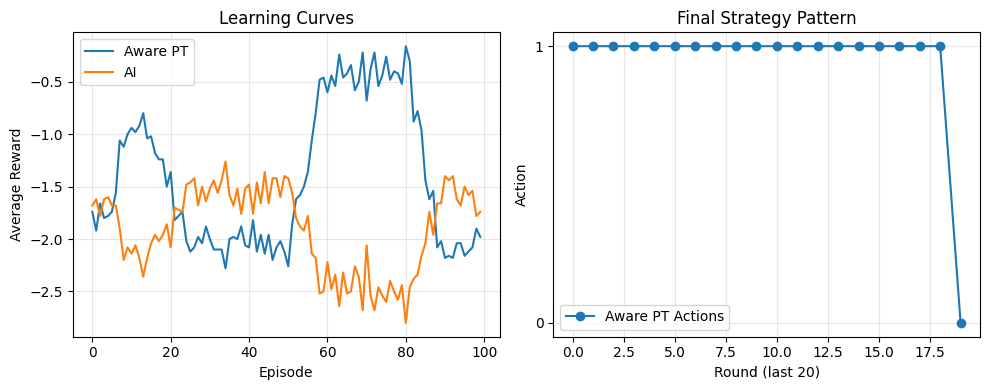


MAIN MENU

Options:
1. Run quick demonstration (fast)
2. Run complete experiment for a specific game
3. Compare all games (summary)
4. Run custom matchup
5. Exit

Running summary comparison across all games...

Analyzing PrisonersDilemma...

Analyzing BattleOfSexes...

Analyzing StagHunt...

Analyzing Chicken...

SUMMARY COMPARISON ACROSS GAMES
            Game  Aware_PT_Avg  AI_Avg  Difference                 Description
PrisonersDilemma        -0.486  -2.469       1.983  Classic Prisoner's Dilemma
   BattleOfSexes         1.150   0.617       0.533         Battle of the Sexes
        StagHunt         3.384   2.607       0.777 Stag Hunt Coordination Game
         Chicken        -1.331   0.231      -1.562                Chicken Game


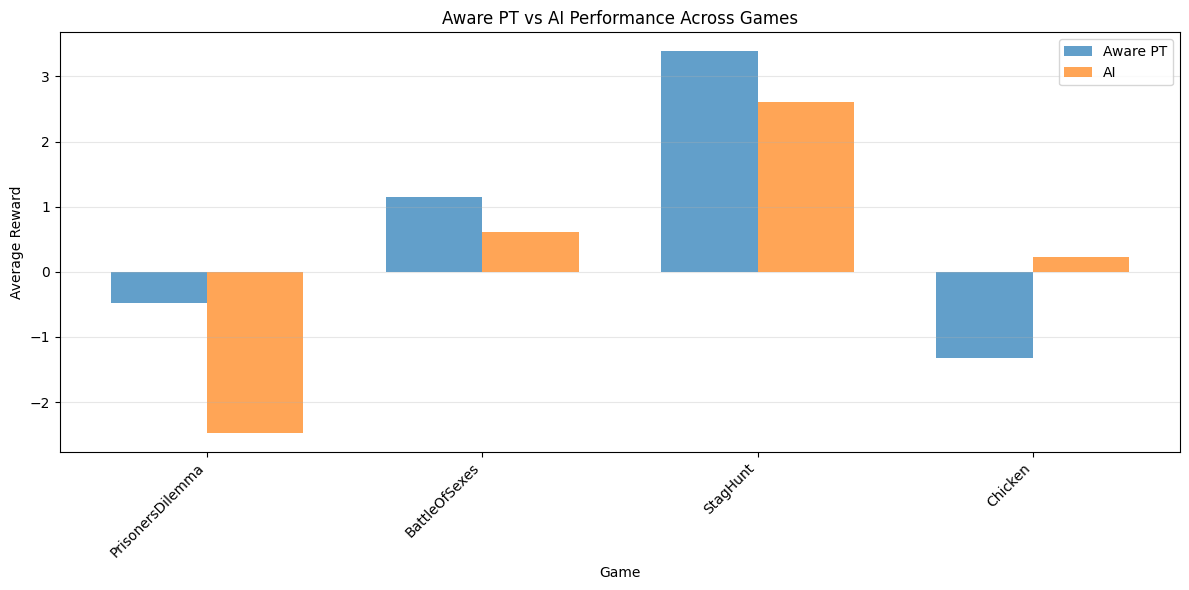

In [ ]:
if __name__ == "__main__":
    # Run the interactive interface
    interactive_experiment()
